In [ ]:
import pandas as pd 
import numpy as np 
import re
from tqdm import tqdm

In [ ]:
%%capture
!pip install transformers --upgrade
!pip install mosestokenizer
!pip install sentencepiece
!pip install ast

In [ ]:
import torch
import transformers
from transformers import BertForSequenceClassification, XLMRobertaForSequenceClassification, AdamW, BertConfig, BertTokenizer, XLMRobertaTokenizer
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from google.colab import drive
import re
from bs4 import BeautifulSoup

In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
'''
Construct object in BERT sentiment classifier class
'''
sentiment_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attention weights.
    output_hidden_states = False # Whether the model returns all hidden states.
)

sentiment_model.cuda() # Puts model on GPU

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
'''
Load pretrained sentiment model parameters
'''
sentiment_model.load_state_dict(torch.load("/content/drive/My Drive/English_sentiment_model.pt", map_location=torch.device('cpu')), strict=False)

_IncompatibleKeys(missing_keys=['bert.embeddings.position_ids'], unexpected_keys=[])

In [ ]:
sentiment_model.eval() # Put model in inference (as opposed to training) mode

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
'''
Load tokenizer for sentiment model
'''
sentiment_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

In [ ]:
# gets the text into the format we want
def clean_tweet(tweet):
  tweet = BeautifulSoup(tweet, "lxml").get_text() # turns xml-formatted text into regular text
  tweet = re.sub(r"@[A-Za-z0-9]+", " ", tweet) # gets rid of all user references in tweets (i.e. "@username")
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", " ", tweet) # gets rid of URLs
  tweet = re.sub(r"[^A-Za-z.!?áéíóúüñ¿ÁÉÍÓÚÜÑ']", " ", tweet) # gets rid of any non-standard characters in the tweets
  tweet = re.sub(r" +", " ", tweet) # replaces all excess whitespace with a single space

  return tweet # gives us our cleaned tweet

In [ ]:
def predict_sentiment(tweet):

    '''
    Predict the sentiment of an input text
    '''
    
    tweet = clean_tweet(tweet)
    tweet_input_id = []
    tweet_attention_mask = []

    tweet_dict = sentiment_tokenizer.encode_plus(
                            tweet,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            truncation=True,           # Explicitly enable truncation
                            padding = 'max_length',
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

    # Add the encoded sentence to the list.    
    tweet_input_id.append(tweet_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    tweet_attention_mask.append(tweet_dict['attention_mask'])

    # Convert the lists into tensors.
    tweet_input_id = torch.cat(tweet_input_id, dim=0)
    tweet_attention_mask = torch.cat(tweet_attention_mask, dim=0)

    tweet_data = TensorDataset(tweet_input_id, tweet_attention_mask)
    
    tweet_dataloader = DataLoader(tweet_data)
    
    for data in tweet_dataloader:
        tweet_input_id = data[0].to(device=torch.device('cuda'))
        tweet_attention_mask = data[1].to(device=torch.device('cuda'))
    
    tweet_logits = sentiment_model(tweet_input_id, token_type_ids=None, attention_mask=tweet_attention_mask)
    
    tweet_logits = tweet_logits[0].detach().cpu().numpy()

    tweet_logits = torch.Tensor(tweet_logits)

    softmax = torch.nn.Softmax(dim=1)
    prob_dist = softmax(tweet_logits)

    sentiment_pred = prob_dist.tolist()

    sentiment_pred = sentiment_pred[0][1]

    return sentiment_pred

In [ ]:
#Another version of semantic distance here 
!pip install transformers
!pip install sentence_transformers 
from transformers import pipeline 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2acb606860b7d6029032b3d4dd6619cf5395f49c49769cd29bef75c1b1b6a0b9
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence_transformers


In [ ]:
#sentence level embeddings 

from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/paraphrase-MiniLM-L6-v2')

#example use 
# sentences = ["Hello World", "Hallo Welt"]
# embeddings = model.encode(sentences)
# print(embeddings)

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/314 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

In [ ]:
generations = pd.read_csv('https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Full/modifiedgenerationfull.csv')

In [ ]:
import math 
from scipy import spatial 
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=2)
def dist(r1, r2):
  r1 = np.array(r1)
  r2 = np.array(r2)
  return spatial.distance.cosine(r1, r2)
# def dist(r1, r2):
#   r1 = np.array(r1)
#   r2 = np.array(r2)
#   return np.linalg.norm((r1 - r2), ord=1)

# **Total Semantic Exploration (adjusted) vs Average Sentiment**

In [ ]:
#semantic exploration vs average sentiment
exploration = {}
individual_sentiment = {}
for id, group in tqdm(generations.groupby("id")):
  exploration[id] = 0
  individual_sentiment[id] = []
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
        individual_sentiment[id].append(predict_sentiment(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

100%|██████████| 197/197 [04:18<00:00,  1.31s/it]


In [ ]:
#find average sentiment 
for id in individual_sentiment:
  individual_sentiment[id] = sum(individual_sentiment[id])/len(individual_sentiment[id])

In [ ]:
x = []
y = []
for id in exploration:
  if .5 < individual_sentiment[id] < .9:
    x.append(individual_sentiment[id])
    y.append(exploration[id])

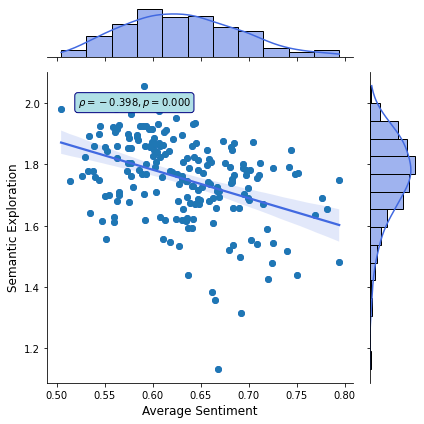

In [ ]:
#display adjusted exploration vs average sentiment 
import seaborn as sns 
import scipy.stats as stats
import matplotlib.pyplot as plt

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Sentiment', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
#save these data into a csv

In [ ]:
#try to combine the above two plots 
import plotnine
from plotnine import ggplot, aes
# package for plot scales
from mizani.formatters import comma_format # (thousands seperator format)

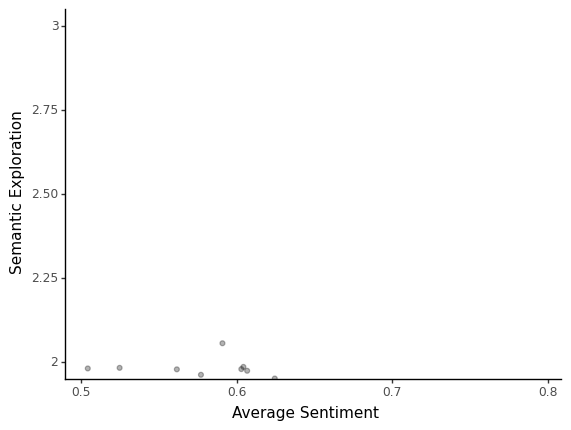

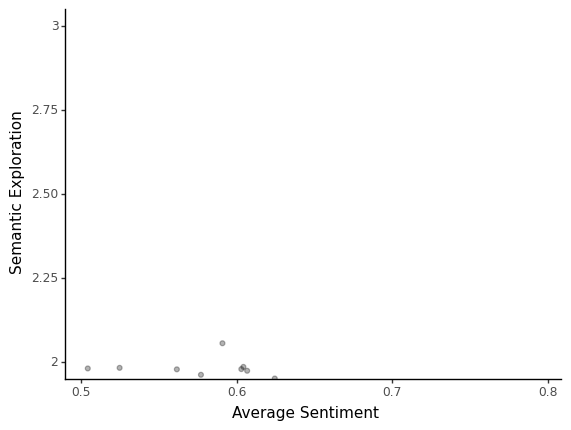

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Sentiment", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Sentiment', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5) + 
 plotnine.xlab("Average Sentiment") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.coords.coord_cartesian(ylim=(2,3)) +
 plotnine.theme_classic()
).draw()




#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


In [ ]:
def average_embedding(embeddings):
  df = pd.DataFrame(embeddings)
  df = df.mean(axis=0)
  return df.values.tolist()

# **Total Semantic Exploration vs Generation Number**

In [ ]:
generations

Unnamed: 0 vignette_name  generation_number  generation_time  \
0               0         Erica                  1                0   
1               1         Erica                  2                0   
2               2         Erica                  3                0   
3               3         Erica                  4                0   
4               4         Erica                  5                0   
...           ...           ...                ...              ...   
12180       12180       Cameron                  2                0   
12181       12181       Cameron                  3                0   
12182       12182       Cameron                  4                0   
12183       12183       Cameron                  5                0   
12184       12184       Cameron                  6                0   

                                                response  reflection_score  \
0                               break one of the windows                 0   
1                                        call the police                 0   
2                                    alert mall security                 0   
3                                ask a stranger for help                 0   
4                                               call 911                 0   
...                                                  ...               ...   
12180                                       Tell her no.                 0   
12181  Take her as far as you are going and drop her off                 0   
12182                                         Call a cab                 0   
12183                    Ask someone else at the station                 0   
12184  Tell her you are going in the opposite direction.                 0   

                     id  
0      YX5fuO4VpL3Et7bB  
1      YX5fuO4VpL3Et7bB  
2      YX5fuO4VpL3Et7bB  
3      YX5fuO4VpL3Et7bB  
4      YX5fuO4VpL3Et7bB  
...                 ...  
12180  1SczUqX7VCwAfGkB  
12181  1SczUqX7VCwAfGkB  
12182  1SczUqX7VCwAfGkB  
12183  1SczUqX7VCwAfGkB  
12184  1SczUqX7VCwAfGkB  

[12185 rows x 7 columns]

In [ ]:
# Real semantic exploration 
#exploration and answers tally average
exploration = {}
answers = {}
#exp and nums tally the individual explorations
exp = []
nums = []
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in exploration: 
      exploration[pnum] = []
      # answers[pnum] = 0
    embeddings = []
    for response, group3 in group2.groupby("response"):
      response = group3['response'].to_list()[0]
      if not pd.isna(response):
        embeddings.append(model.encode(response).tolist())
    # answers[pnum] += len(embeddings)
    if len(embeddings) > 0:
      e = 0
      for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
          e += dist(embeddings[i], embeddings[j])
      exploration[pnum].append(e/len(embeddings))
      exp.append(e/len(embeddings))
      nums.append(pnum)

x_avg = []
y_avg = []
for num in exploration:
  x_avg.append(num)
  y_avg.append(sum(exploration[num])/len(exploration[num]))

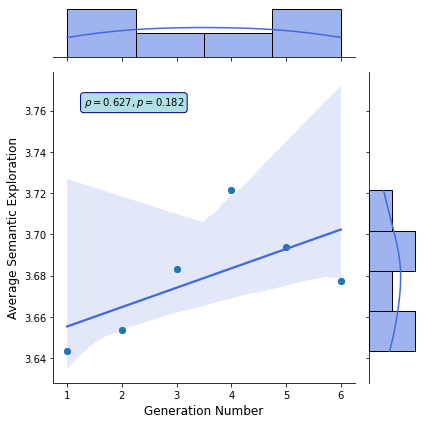

In [ ]:
#plotting for stats
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,exp])
d = d.T
d.columns = ["Generation_Number", "Semantic_Exploration"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Exploration"]

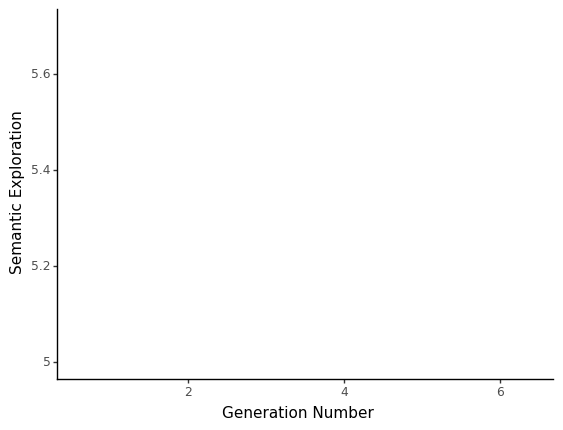

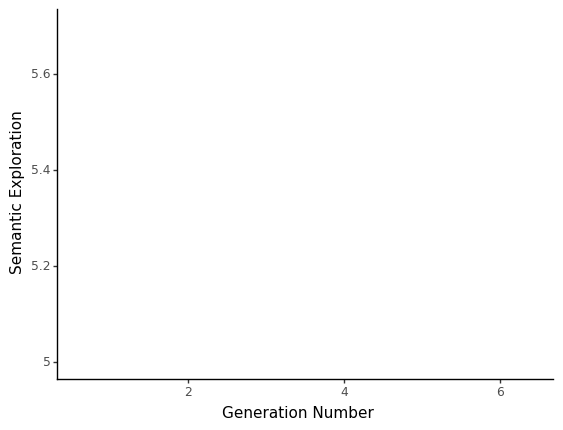

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Exploration"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Exploration-yerr",ymax="Semantic_Exploration+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Exploration") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(5,5.70)) +
 plotnine.theme_classic()
  ).draw()

In [ ]:
def total_variation(e):
  variation = 0
  count = 0
  for i in range(len(e)):
    for j in range(i+1, len(e)):
      variation += dist(e[i], e[j])
      count += 1
      if count%10000==0:
        print("done")
  return variation

# **Semantic Dissimilarity vs Generation Number**

In [ ]:
# Semantic space similarity vs possibiltiy number (pairwise sim between all avg. embedding vectors)
vectordic = {}
for id, group in generations.groupby("id"):
  for pnum, group2 in group.groupby("generation_number"):
    if pnum not in vectordic:
      vectordic[pnum] = []
    embeddings = []
    for generation in group2['response']:
      if not pd.isna(generation):
        embeddings.append(model.encode(generation))
    embeddings = pd.DataFrame(embeddings)
    embeddings = embeddings.mean(axis=0)
    embeddings = embeddings.values.tolist()
    if len(embeddings) > 0:
      vectordic.get(pnum).append(embeddings)


In [ ]:
#semantic space dissimilarity vs generation nums
similarity = []
nums = []
avg_dic = {}
for num in vectordic:
  avg_dic[num] = []
  for i in range(len(vectordic.get(num))):
    for j in range(i+1, len(vectordic.get(num))):
      nums.append(num)
      s = dist(vectordic.get(num)[i], vectordic.get(num)[j])
      similarity.append(s)
      avg_dic[num].append(s)


In [ ]:
# remove invalid data - why would the distance between two distinct localizing vectors be 0? 
x = nums
y = similarity
i = 0 
avg_dic = {}
while i < len(x):
  if y[i] == 0:
    y.pop(i)
    x.pop(i)
    i -= 1
  else:
    if x[i] not in avg_dic:
      avg_dic[x[i]] = []
    avg_dic[x[i]].append(y[i])
  i += 1
x_avg = []
y_avg = []
for num in avg_dic:
  avg_dic[num] = sum(avg_dic[num])/len(avg_dic[num])
  x_avg.append(num)
  y_avg.append(avg_dic[num])

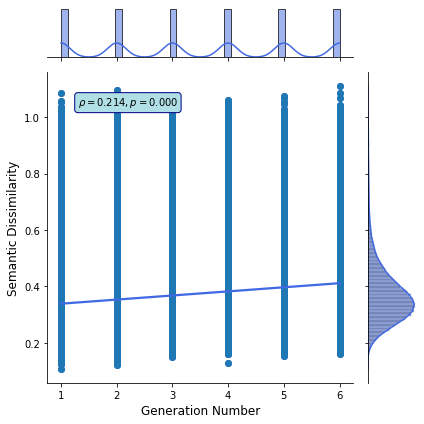

In [ ]:
#plotting to find stats 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

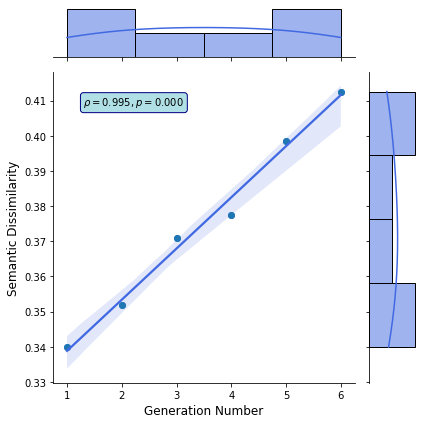

In [ ]:
#plotting to find stats 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Semantic_Dissimilarity"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Semantic_Dissimilarity"]

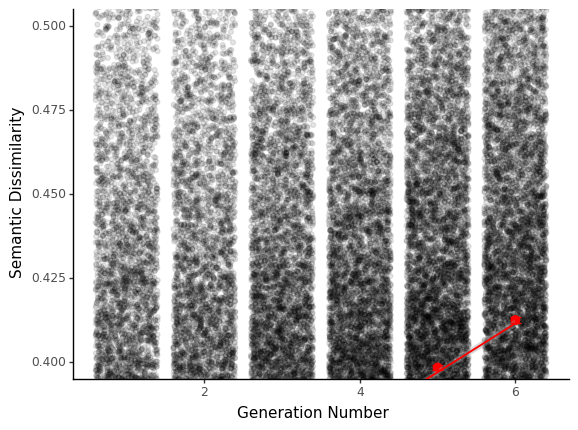

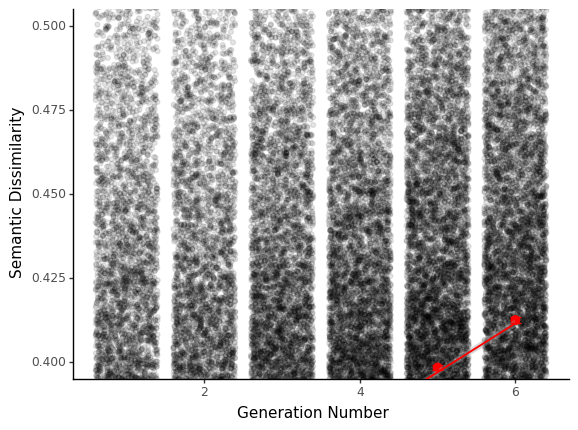

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Semantic_Dissimilarity"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.1) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Semantic_Dissimilarity-yerr",ymax="Semantic_Dissimilarity+yerr"), color="red",width=.15) + 
 plotnine.ylab("Semantic Dissimilarity") +
 plotnine.xlab("Generation Number") +
  plotnine.coords.coord_cartesian(ylim=(.4,.5)) +
 plotnine.theme_classic()
  ).draw()

# **Subjective Goodness vs Generation Number**

In [ ]:
#average goodness rating per possibility 
scores = [[] for i in range(6)]
nums = [i for i in range(6)]

#all of the ratings 
s = []
n = []

for pnum, group1 in generations.groupby("generation_number"):
  for score in group1['reflection_score']:
    scores[pnum-1].append(score)
    s.append(score)
    n.append(pnum)

for i in range(len(scores)):
  scores[i] = sum(scores[i])/len(scores[i])

/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


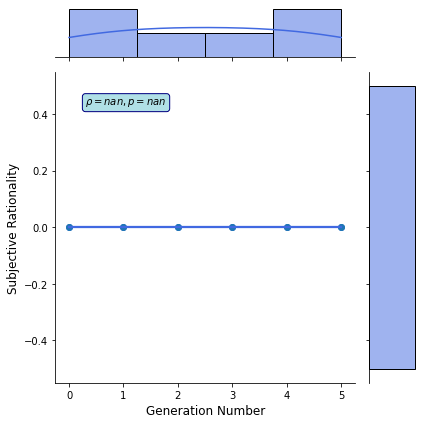

In [ ]:
#plotting for stats
x_avg = np.array(nums) 
y_avg = np.array(scores)

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Subjective Rationality', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[n,s])
d = d.T
d.columns = ["Generation_Number", "Generation_Goodness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Goodness"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Goodness"]/(len(group["Generation_Goodness"])**.5))
d2["yerr"] = errors


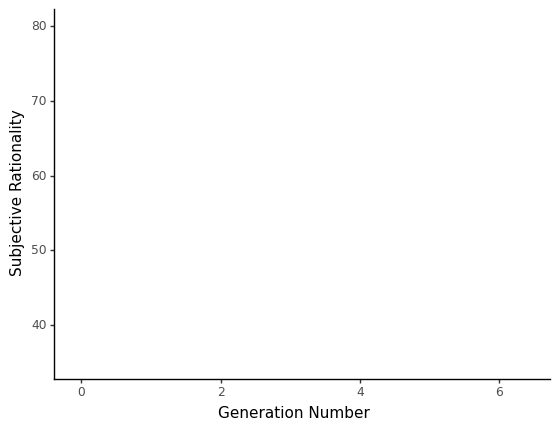

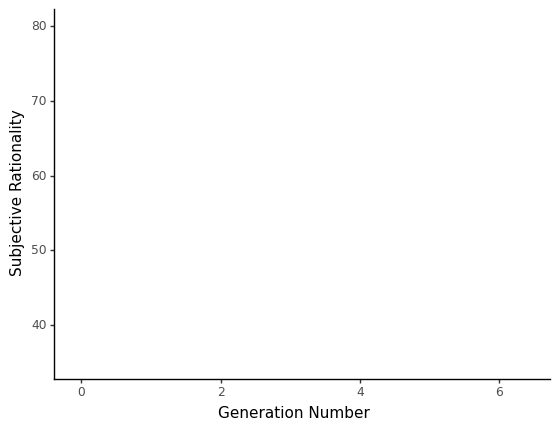

In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Goodness'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Goodness-yerr",ymax="Generation_Goodness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Subjective Rationality") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic()  +
 plotnine.coords.coord_cartesian(ylim=(35,80)) 
 ).draw()

# **Generation Sentiment vs Generation Number**

In [ ]:
#generation sentiment vs generation number

sentiment = []
nums = []
avg_sentiment = {}
for id, participant in generations.groupby('id'):
  for pos_num, group in participant.groupby('generation_number'):
    if pos_num not in avg_sentiment:
      avg_sentiment[pos_num] = []
    for generation in group['response']:
      if not pd.isna(generation):
        s = predict_sentiment(generation)
        sentiment.append(s)
        nums.append(pos_num)
        avg_sentiment[pos_num].append(s)

In [ ]:
x = nums
y = sentiment

x_avg = []
y_avg = []
for num in avg_sentiment:
  x_avg.append(num)
  y_avg.append(sum(avg_sentiment[num])/len(avg_sentiment[num]))

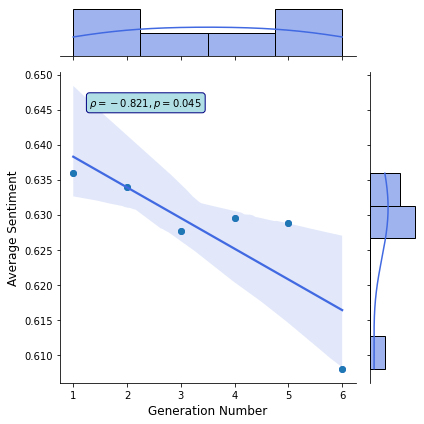

In [ ]:
#plotting for stats 
g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Average Sentiment', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Generation_Number", "Generation_Sentiment"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Sentiment"]

errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Sentiment"]/(len(group["Generation_Sentiment"])**.5))
d2["yerr"] = errors


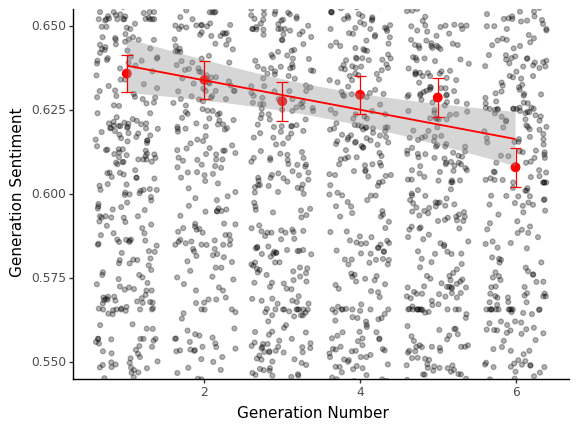

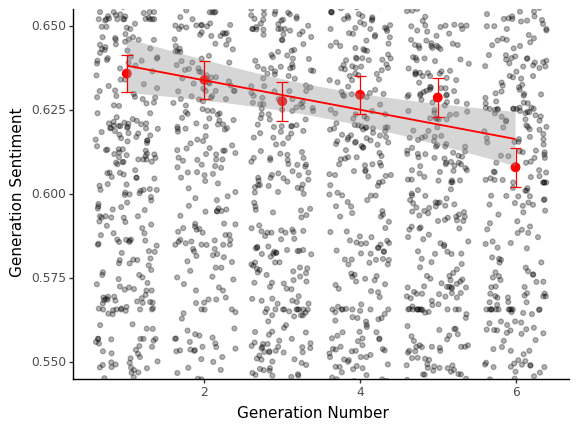

In [ ]:
scatter = ggplot(data=d, mapping=aes(x='Generation_Number', y='Generation_Sentiment'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.75, color="red") + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Sentiment-yerr",ymax="Generation_Sentiment+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Sentiment") +
 plotnine.xlab("Generation Number") + 
 plotnine.theme_classic() +
 plotnine.coords.coord_cartesian(ylim=(.55,.65)) 
).draw()

# **Generation Concreteness vs Generation Number**

In [ ]:
concreteness = pd.read_csv("https://raw.githubusercontent.com/gokulsrin/PossibilityGeneration/main/Misc/Concreteness_ratings_Brysbaert_et_al_BRM.csv")

In [ ]:
#create concreteness dict
concreteness_dict = {}
for word, group in concreteness.groupby("Word"):
  rating = group["Conc.M"].values[0]
  concreteness_dict[word] = rating

In [ ]:
#figure out if later generations are more or less concrete 
import string 

conc = []
nums = []
cdic = {}
for id, group in generations.groupby("id"):
  for vign, group2 in group.groupby("vignette_name"):
    for num, group3 in group2.groupby("generation_number"):
      for response, group4 in group3.groupby("response"):
        if not pd.isna(response):
          response = response.translate(str.maketrans('', '', string.punctuation))
          score = []
          l = len(response.split(" "))
          for word in response.split(" "):
            if word in concreteness_dict:
              score.append(concreteness_dict[word])
          if len(score) > 0:
            score = sum(score)/len(score)
            # score = (sum(score)/len(score))/l
            conc.append(score)
            nums.append(num)
            if num not in cdic:
              cdic[num] = []
            cdic[num].append(score)

In [ ]:
#find averages in concreteness differences
x_avg = []
y_avg = [] 
for key in cdic:
  cdic[key] = sum(cdic[key])/len(cdic[key])
  x_avg.append(key)
  y_avg.append(cdic[key])

print(cdic)

{1: 2.7767954178691747, 2: 2.755848183513439, 3: 2.719223207388812, 4: 2.7368169596840737, 5: 2.718266124602115, 6: 2.7033914427220993}


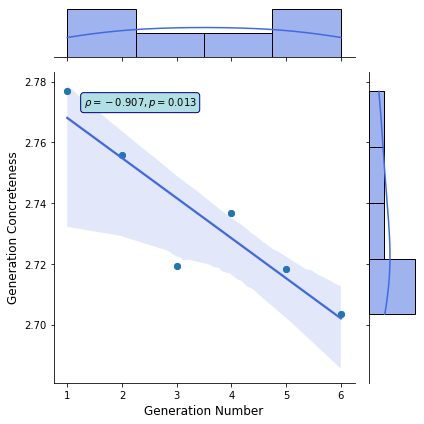

In [ ]:
#just for stats

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Generation Number', ylabel='Generation Concreteness', size=12)
plt.tight_layout()
plt.show()

In [ ]:
d = pd.DataFrame(data=[nums,conc])
d = d.T
d.columns = ["Generation_Number", "Generation_Concreteness"]

d2 = pd.DataFrame(data=[x_avg,y_avg])
d2 = d2.T
d2.columns = ["Generation_Number", "Generation_Concreteness"]

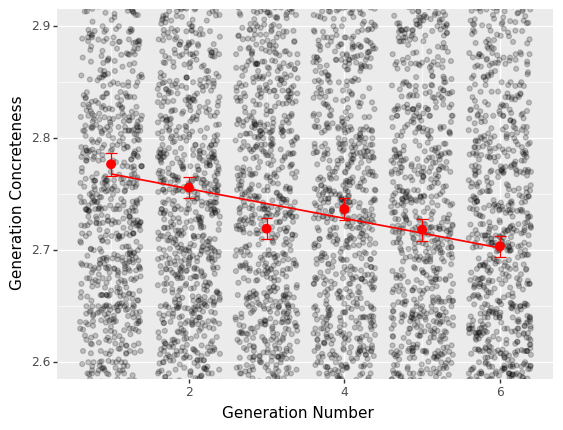

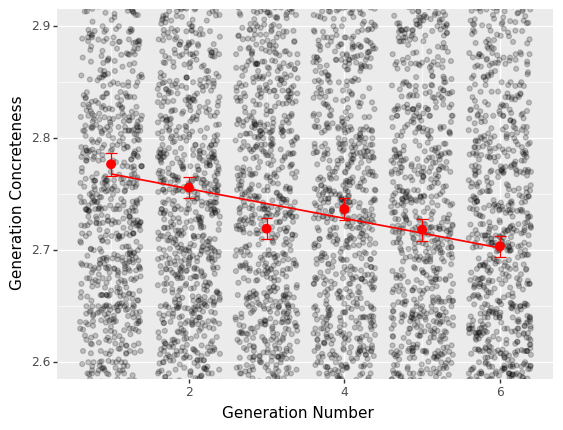

In [ ]:
errors = []
for num, group in d.groupby("Generation_Number"):
  errors.append(group.std()["Generation_Concreteness"]/(len(group))**.5)
d2["yerr"] = errors

scatter = ggplot(data=d2, mapping=aes(x='Generation_Number', y='Generation_Concreteness', ymin=2.7))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.2) +
 plotnine.geom_point(data=d2, color="red", size=3) +
 plotnine.geom_smooth(method="lm",size=.70, color="red", se=False) + 
 plotnine.geom_errorbar(d2,aes(x="Generation_Number", ymin="Generation_Concreteness-yerr",ymax="Generation_Concreteness+yerr"), color="red",width=.15) + 
 plotnine.ylab("Generation Concreteness") +
 plotnine.xlab("Generation Number") + 
  plotnine.coords.coord_cartesian(ylim=(2.6,2.9))
  ).draw()

# **Concreteness vs Semantic Relatedness**

In [ ]:
#bin the generations based on concreteness 
gens = {}
for response, group in generations.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      score = sum(score)/len(score)
      gens[response] = score

In [ ]:
#bin all of the responses : num bins = 10 
gens = dict(sorted(gens.items(), key=lambda item: item[1]))
len(gens)

10385

In [ ]:
nbins = 100
bins = [[] for j in range(nbins)]
i = 0 
for item in gens:
  if i//int(len(gens)/nbins) < nbins:
    bins[i//int(len(gens)/nbins)].append((item, gens[item]))
  i += 1

In [ ]:
from tqdm import tqdm

In [ ]:
similarity = {}
for b in tqdm(range(len(bins))):
  if b not in similarity: 
    similarity[b] = []
  bin = bins[b]
  embeddings = {}
  for response in bin:
    response = response[0]
    embeddings[response] = model.encode(response)
  for i in range(len(bin)):
    for j in range(i+1, len(bin)):
      similarity[b].append(dist(embeddings[bin[i][0]], embeddings[bin[j][0]]))
  print(b)
similarity 


  1%|          | 1/100 [00:01<01:41,  1.03s/it]

0


  2%|▏         | 2/100 [00:02<01:41,  1.03s/it]

1


  3%|▎         | 3/100 [00:03<01:43,  1.06s/it]

2


  4%|▍         | 4/100 [00:04<01:40,  1.05s/it]

3


  5%|▌         | 5/100 [00:05<01:37,  1.03s/it]

4


  6%|▌         | 6/100 [00:06<01:36,  1.03s/it]

5


  7%|▋         | 7/100 [00:07<01:36,  1.04s/it]

6


  8%|▊         | 8/100 [00:08<01:36,  1.05s/it]

7


  9%|▉         | 9/100 [00:09<01:38,  1.08s/it]

8


 10%|█         | 10/100 [00:10<01:37,  1.08s/it]

9


 11%|█         | 11/100 [00:11<01:34,  1.06s/it]

10


 12%|█▏        | 12/100 [00:12<01:32,  1.05s/it]

11


 13%|█▎        | 13/100 [00:13<01:32,  1.06s/it]

12


 14%|█▍        | 14/100 [00:14<01:30,  1.06s/it]

13


 15%|█▌        | 15/100 [00:15<01:31,  1.07s/it]

14


 16%|█▌        | 16/100 [00:16<01:31,  1.09s/it]

15


 17%|█▋        | 17/100 [00:18<01:30,  1.10s/it]

16


 18%|█▊        | 18/100 [00:19<01:27,  1.06s/it]

17


 19%|█▉        | 19/100 [00:20<01:27,  1.08s/it]

18


 20%|██        | 20/100 [00:21<01:26,  1.08s/it]

19


 21%|██        | 21/100 [00:22<01:25,  1.09s/it]

20


 22%|██▏       | 22/100 [00:23<01:25,  1.09s/it]

21


 23%|██▎       | 23/100 [00:24<01:22,  1.07s/it]

22


 24%|██▍       | 24/100 [00:25<01:22,  1.08s/it]

23


 25%|██▌       | 25/100 [00:26<01:20,  1.07s/it]

24


 26%|██▌       | 26/100 [00:27<01:18,  1.07s/it]

25


 27%|██▋       | 27/100 [00:28<01:17,  1.06s/it]

26


 28%|██▊       | 28/100 [00:29<01:15,  1.05s/it]

27


 29%|██▉       | 29/100 [00:30<01:14,  1.04s/it]

28


 30%|███       | 30/100 [00:31<01:12,  1.04s/it]

29


 31%|███       | 31/100 [00:32<01:11,  1.04s/it]

30


 32%|███▏      | 32/100 [00:33<01:09,  1.03s/it]

31


 33%|███▎      | 33/100 [00:34<01:09,  1.04s/it]

32


 34%|███▍      | 34/100 [00:36<01:10,  1.08s/it]

33


 35%|███▌      | 35/100 [00:37<01:09,  1.07s/it]

34


 36%|███▌      | 36/100 [00:38<01:09,  1.09s/it]

35


 37%|███▋      | 37/100 [00:39<01:07,  1.07s/it]

36


 38%|███▊      | 38/100 [00:40<01:06,  1.08s/it]

37


 39%|███▉      | 39/100 [00:41<01:04,  1.06s/it]

38


 40%|████      | 40/100 [00:42<01:05,  1.09s/it]

39


 41%|████      | 41/100 [00:43<01:04,  1.10s/it]

40


 42%|████▏     | 42/100 [00:44<01:02,  1.09s/it]

41


 43%|████▎     | 43/100 [00:45<01:01,  1.08s/it]

42


 44%|████▍     | 44/100 [00:46<00:59,  1.06s/it]

43


 45%|████▌     | 45/100 [00:47<00:59,  1.08s/it]

44


 46%|████▌     | 46/100 [00:48<00:57,  1.06s/it]

45


 47%|████▋     | 47/100 [00:50<00:56,  1.07s/it]

46


 48%|████▊     | 48/100 [00:51<00:55,  1.08s/it]

47


 49%|████▉     | 49/100 [00:52<00:55,  1.08s/it]

48


 50%|█████     | 50/100 [00:53<00:54,  1.09s/it]

49


 51%|█████     | 51/100 [00:54<00:53,  1.09s/it]

50


 52%|█████▏    | 52/100 [00:55<00:52,  1.09s/it]

51


 53%|█████▎    | 53/100 [00:56<00:50,  1.07s/it]

52


 54%|█████▍    | 54/100 [00:57<00:49,  1.07s/it]

53


 55%|█████▌    | 55/100 [00:58<00:47,  1.06s/it]

54


 56%|█████▌    | 56/100 [00:59<00:47,  1.08s/it]

55


 57%|█████▋    | 57/100 [01:00<00:46,  1.08s/it]

56


 58%|█████▊    | 58/100 [01:02<00:45,  1.08s/it]

57


 59%|█████▉    | 59/100 [01:03<00:44,  1.09s/it]

58


 60%|██████    | 60/100 [01:04<00:43,  1.09s/it]

59


 61%|██████    | 61/100 [01:05<00:43,  1.11s/it]

60


 62%|██████▏   | 62/100 [01:06<00:40,  1.07s/it]

61


 63%|██████▎   | 63/100 [01:07<00:39,  1.06s/it]

62


 64%|██████▍   | 64/100 [01:08<00:38,  1.06s/it]

63


 65%|██████▌   | 65/100 [01:09<00:37,  1.07s/it]

64


 66%|██████▌   | 66/100 [01:10<00:36,  1.07s/it]

65


 67%|██████▋   | 67/100 [01:11<00:34,  1.04s/it]

66


 68%|██████▊   | 68/100 [01:12<00:33,  1.04s/it]

67


 69%|██████▉   | 69/100 [01:13<00:32,  1.05s/it]

68


 70%|███████   | 70/100 [01:14<00:31,  1.04s/it]

69


 71%|███████   | 71/100 [01:15<00:29,  1.03s/it]

70


 72%|███████▏  | 72/100 [01:16<00:29,  1.06s/it]

71


 73%|███████▎  | 73/100 [01:17<00:28,  1.06s/it]

72


 74%|███████▍  | 74/100 [01:18<00:27,  1.04s/it]

73


 75%|███████▌  | 75/100 [01:20<00:26,  1.07s/it]

74


 76%|███████▌  | 76/100 [01:21<00:26,  1.10s/it]

75


 77%|███████▋  | 77/100 [01:22<00:25,  1.10s/it]

76


 78%|███████▊  | 78/100 [01:23<00:23,  1.07s/it]

77


 79%|███████▉  | 79/100 [01:24<00:21,  1.05s/it]

78


 80%|████████  | 80/100 [01:25<00:21,  1.06s/it]

79


 81%|████████  | 81/100 [01:26<00:20,  1.07s/it]

80


 82%|████████▏ | 82/100 [01:27<00:19,  1.06s/it]

81


 83%|████████▎ | 83/100 [01:28<00:18,  1.06s/it]

82


 84%|████████▍ | 84/100 [01:29<00:16,  1.05s/it]

83


 85%|████████▌ | 85/100 [01:30<00:15,  1.06s/it]

84


 86%|████████▌ | 86/100 [01:31<00:14,  1.06s/it]

85


 87%|████████▋ | 87/100 [01:32<00:13,  1.05s/it]

86


 88%|████████▊ | 88/100 [01:33<00:12,  1.04s/it]

87


 89%|████████▉ | 89/100 [01:34<00:11,  1.04s/it]

88


 90%|█████████ | 90/100 [01:35<00:10,  1.07s/it]

89


 91%|█████████ | 91/100 [01:37<00:09,  1.05s/it]

90


 92%|█████████▏| 92/100 [01:38<00:08,  1.08s/it]

91


 93%|█████████▎| 93/100 [01:39<00:07,  1.08s/it]

92


 94%|█████████▍| 94/100 [01:40<00:06,  1.07s/it]

93


 95%|█████████▌| 95/100 [01:41<00:05,  1.06s/it]

94


 96%|█████████▌| 96/100 [01:42<00:04,  1.05s/it]

95


 97%|█████████▋| 97/100 [01:43<00:03,  1.06s/it]

96


 98%|█████████▊| 98/100 [01:44<00:02,  1.05s/it]

97


 99%|█████████▉| 99/100 [01:45<00:01,  1.05s/it]

98


100%|██████████| 100/100 [01:46<00:00,  1.07s/it]

99


{0: [0.8694436997175217,
  0.8769991099834442,
  0.7897406965494156,
  1.0206671133637428,
  0.8410821408033371,
  0.8827776834368706,
  0.9761770982295275,
  0.9397674202919006,
  1.1089411079883575,
  0.8543905913829803,
  0.900954432785511,
  0.813074454665184,
  0.3351476192474365,
  0.8887520805001259,
  0.8887520805001259,
  0.8615250885486603,
  0.8487163782119751,
  0.9777178131043911,
  0.7347153425216675,
  0.8229346871376038,
  0.8696336597204208,
  0.8696336597204208,
  0.8696336597204208,
  0.7318586111068726,
  1.0459251329302788,
  0.9209762439131737,
  0.7476903796195984,
  0.8952797427773476,
  0.9164058715105057,
  1.00118385523092,
  0.8486383110284805,
  0.5529171824455261,
  0.8372717648744583,
  0.8439208269119263,
  0.9351359903812408,
  0.809478297829628,
  0.8808054998517036,
  0.9945420497097075,
  0.7904422730207443,
  0.8838883191347122,
  0.9454113729298115,
  1.0340388379991055,
  0.9236992970108986,
  0.8983891159296036,
  0.7467089891433716,
  0.72494754

In [ ]:
buckets = {}
for key in similarity:
  buckets[key] = sum(similarity[key])/len(similarity[key])

In [ ]:
x_avg = []
y_avg = []

for key in buckets:
  x_avg.append(key)
  y_avg.append(buckets[key])

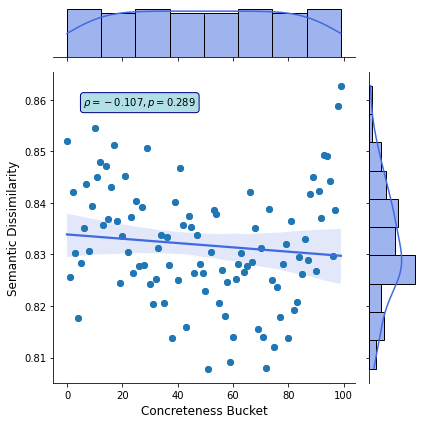

In [ ]:
# to be clear, higher buckets have higher concreteness. 

g = sns.jointplot(x=x_avg, y=y_avg, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x_avg, y_avg)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x_avg, y_avg)
g.set_axis_labels(xlabel='Concreteness Bucket', ylabel='Semantic Dissimilarity', size=12)
plt.tight_layout()
plt.show()

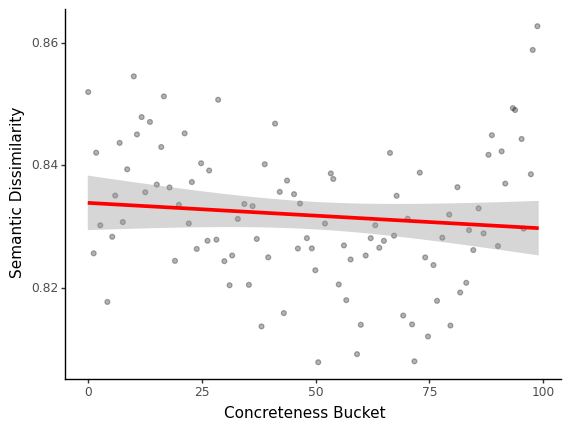

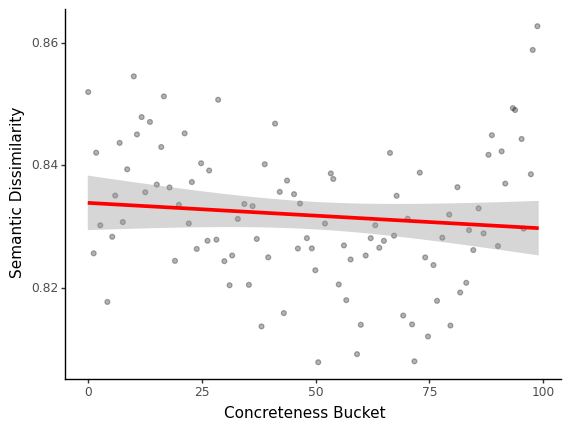

In [ ]:
d = pd.DataFrame(data=[x_avg,y_avg])
d = d.T
d.columns = ["Concreteness_Bucket", "Semantic_Dissimilarity"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Concreteness_Bucket', y='Semantic_Dissimilarity'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Concreteness Bucket") +
 plotnine.ylab("Semantic Dissimilarity") + 
 plotnine.theme_classic()
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Semantic Exploration vs Average Concreteness**

In [ ]:
# semantic exploration 
exploration = {}
for id, group in generations.groupby("id"):
  exploration[id] = 0
  len_responses = 0
  for vign, group2 in group.groupby("vignette_name"):
    embeddings = []
    for response, group3 in group2.groupby("response"):
      if not pd.isna(response):
        embeddings.append(model.encode(response))
    len_responses += len(embeddings)
    for i in range(len(embeddings)):
      for j in range(i+1, len(embeddings)):
        exploration[id] += dist(embeddings[i], embeddings[j])
  exploration[id] /= len_responses

In [ ]:
#determine avg concreteness 
id_concreteness = {}
for id, group in generations.groupby("id"):
  for response, group2 in group.groupby("response"):
    response = response.translate(str.maketrans('', '', string.punctuation))
    score = []
    l = len(response.split(" "))
    for word in response.split(" "):
      if word in concreteness_dict:
        score.append(concreteness_dict[word])
    if len(score) > 0:
      if id not in id_concreteness:
        id_concreteness[id] = []
      score = sum(score)/len(score)
      id_concreteness[id].append(score)

In [ ]:
for id in id_concreteness:
  id_concreteness[id] = sum(id_concreteness[id])/len(id_concreteness[id])

In [ ]:
x = []
y = []
for id in id_concreteness:
  if id in exploration:
    x.append(id_concreteness[id])
    y.append(exploration[id])

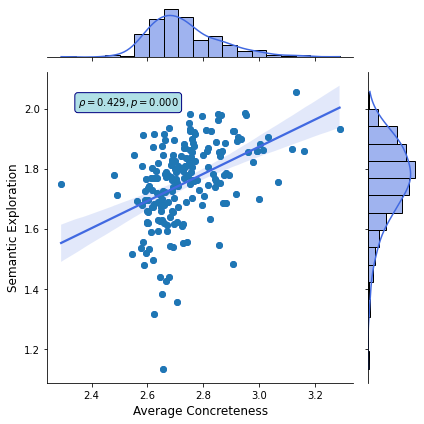

In [ ]:
#display adjusted exploration vs average sentiment 
g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Average Concreteness', ylabel='Semantic Exploration', size=12)
plt.tight_layout()
plt.show()

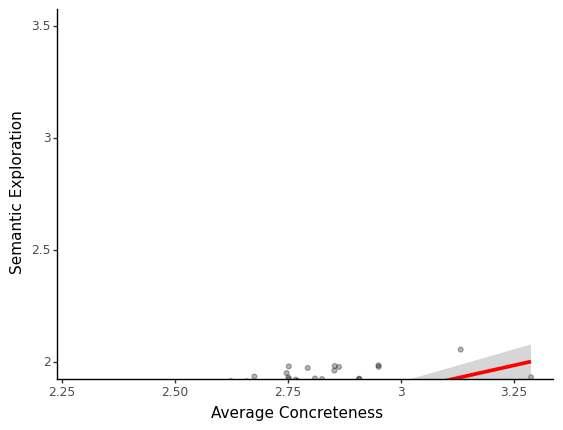

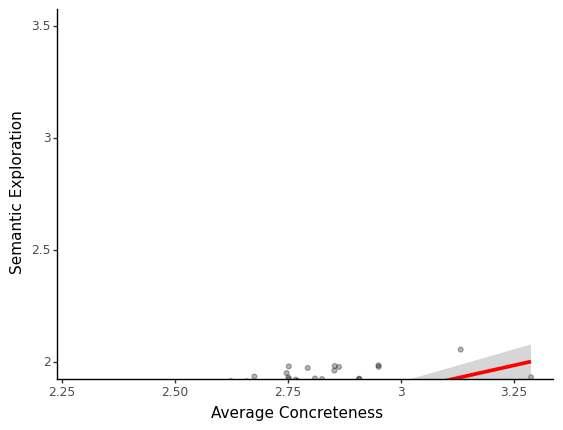

In [ ]:
d = pd.DataFrame(data=[x,y])
d = d.T
d.columns = ["Average_Concreteness", "Semantic_Exploration"]
# d[(np.abs(stats.zscore(d)) < 3).all(axis=1)]

scatter = ggplot(data=d, mapping=aes(x='Average_Concreteness', y='Semantic_Exploration'))
# add layers
(scatter + 
 plotnine.geom_jitter(data=d, color="black", alpha=0.3) +
 plotnine.geom_smooth(method="lm",size=1.5, color="red") + 
 plotnine.xlab("Average Concreteness") +
 plotnine.ylab("Semantic Exploration") + 
 plotnine.theme_classic() + 
 plotnine.coords.coord_cartesian(ylim=(2,3.5))
).draw()

#this reduces this axis to bwtween 0 and 1 
#  plotnine.scale_y_continuous(limits=(0, 1))


# **Generation Concreteness vs Subjective Score**

In [ ]:
concreteness = []
subjective = []
for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0 :
    score = sum(score)/len(score)
    concreteness.append(score)
    subjective.append(list(group["reflection_score"])[0])


/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


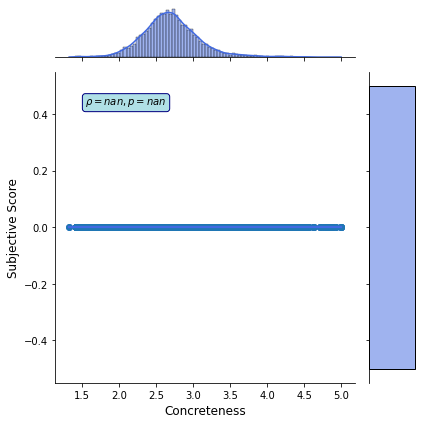

In [ ]:
x = concreteness
y = subjective

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Subjective Score', size=12)
plt.tight_layout()
plt.show()

# **Generation Concreteness vs Generation Sentiment**

In [ ]:
concreteness = []
sentiment = []
for response, group in generations.groupby("response"):
  response = response.translate(str.maketrans('', '', string.punctuation))
  score = []
  l = len(response.split(" "))
  for word in response.split(" "):
    if word in concreteness_dict:
      score.append(concreteness_dict[word])
  if len(score) > 0:
    score = sum(score)/len(score)
    concreteness.append(score)
    sentiment.append(predict_sentiment(response))


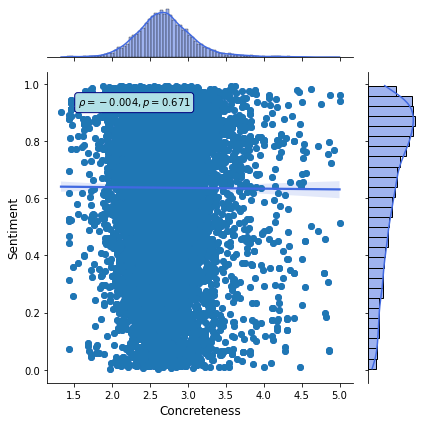

In [ ]:
x = concreteness
y = sentiment

g = sns.jointplot(x=x, y=y, kind='reg', color='royalblue')
# ax.annotate(stats.pearsonr)
r, p = stats.pearsonr(x, y)
g.ax_joint.annotate(f'$\\rho = {r:.3f}, p = {p:.3f}$',
                    xy=(0.1, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'round', 'fc': 'powderblue', 'ec': 'navy'})
g.ax_joint.scatter(x, y)
g.set_axis_labels(xlabel='Concreteness', ylabel='Sentiment', size=12)
plt.tight_layout()
plt.show()